In [1]:
from pandas import concat
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error ,mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
import numpy as np
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import os

C:\Users\Administrator\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

# prepare data for lstm
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
 # load dataset
dataset = read_csv('solar_training.csv', header=0, index_col=0)
cols = ["VAR78","VAR79","VAR134","VAR157","VAR164","VAR165","VAR166","VAR167","VAR169","VAR175","VAR178","VAR228","POWER"]
values = dataset.loc[:,cols].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 24)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[13,14,15,16,17,18,19,20,21,22,23,24]], axis=1, inplace=True)
print(reframed.head())
values_ = reframed.values

# test new data
dataset_test = read_csv('solar_test.csv', header=0, index_col=0)
cols = ["VAR78","VAR79","VAR134","VAR157","VAR164","VAR165","VAR166","VAR167","VAR169","VAR175","VAR178","VAR228","POWER"]
values_test = dataset_test.loc[:,cols].values
# ensure all data is float
values_test = values_test.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler.fit_transform(values_test)
# frame as supervised learning
reframed_test = series_to_supervised(scaled_test, 1, 24)
# drop columns we don't want to predict
reframed_test.drop(reframed_test.columns[[13,14,15,16,17,18,19,20,21,22,23,24]], axis=1, inplace=True)
print(reframed_test.head())

# split into train and test sets
values_test_ = reframed_test.values

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000951   0.005949   0.753838   0.554294   0.244599   0.452893   
2   0.002670   0.055345   0.739433   0.494858   0.457134   0.518611   
3   0.014555   0.217604   0.735210   0.565799   0.771424   0.557628   
4   0.027631   0.182389   0.730377   0.635282   0.965859   0.546985   
5   0.024663   0.312472   0.725492   0.660990   0.944661   0.523996   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var4(t+23)  var5(t+23)  \
1   0.308717   0.614149   0.070835    0.011362  ...    0.658423    0.830270   
2   0.283068   0.643875   0.151890    0.048668  ...    0.612491    0.685297   
3   0.335947   0.614300   0.226743    0.085685  ...    0.552709    0.768793   
4   0.364012   0.584816   0.283305    0.122869  ...    0.493075    0.538906   
5   0.340029   0.571754   0.320724    0.162833  ...    0.456895    0.486813   

   var6(t+23)  var7(t+23)  var8(t+23)  var9(t+23)  var10(t+23)  var11(t+23)  \
1    0.421167    0.

(10944, 1, 312) (10944,) (10943, 1, 312) (10943,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               410400    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 410,601
Trainable params: 410,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200

Epoch 1: val_loss improved from inf to 0.16481, saving model to best_model.h5
152/152 - 2s - loss: 0.1691 - val_loss: 0.1648 - 2s/epoch - 15ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.16481 to 0.16249, saving model to best_model.h5
152/152 

152/152 - 1s - loss: 0.0608 - val_loss: 0.0596 - 1s/epoch - 8ms/step
Epoch 46/200

Epoch 46: val_loss improved from 0.05965 to 0.05878, saving model to best_model.h5
152/152 - 1s - loss: 0.0598 - val_loss: 0.0588 - 1s/epoch - 7ms/step
Epoch 47/200

Epoch 47: val_loss improved from 0.05878 to 0.05795, saving model to best_model.h5
152/152 - 1s - loss: 0.0589 - val_loss: 0.0580 - 1s/epoch - 7ms/step
Epoch 48/200

Epoch 48: val_loss improved from 0.05795 to 0.05714, saving model to best_model.h5
152/152 - 1s - loss: 0.0581 - val_loss: 0.0571 - 1s/epoch - 8ms/step
Epoch 49/200

Epoch 49: val_loss improved from 0.05714 to 0.05641, saving model to best_model.h5
152/152 - 1s - loss: 0.0572 - val_loss: 0.0564 - 1s/epoch - 7ms/step
Epoch 50/200

Epoch 50: val_loss improved from 0.05641 to 0.05566, saving model to best_model.h5
152/152 - 1s - loss: 0.0564 - val_loss: 0.0557 - 1s/epoch - 7ms/step
Epoch 51/200

Epoch 51: val_loss improved from 0.05566 to 0.05496, saving model to best_model.h5
152/

Epoch 95/200

Epoch 95: val_loss improved from 0.04035 to 0.04019, saving model to best_model.h5
152/152 - 1s - loss: 0.0394 - val_loss: 0.0402 - 1s/epoch - 7ms/step
Epoch 96/200

Epoch 96: val_loss improved from 0.04019 to 0.04007, saving model to best_model.h5
152/152 - 1s - loss: 0.0394 - val_loss: 0.0401 - 1s/epoch - 7ms/step
Epoch 97/200

Epoch 97: val_loss improved from 0.04007 to 0.04000, saving model to best_model.h5
152/152 - 1s - loss: 0.0392 - val_loss: 0.0400 - 1s/epoch - 7ms/step
Epoch 98/200

Epoch 98: val_loss improved from 0.04000 to 0.03984, saving model to best_model.h5
152/152 - 1s - loss: 0.0391 - val_loss: 0.0398 - 1s/epoch - 7ms/step
Epoch 99/200

Epoch 99: val_loss improved from 0.03984 to 0.03983, saving model to best_model.h5
152/152 - 1s - loss: 0.0389 - val_loss: 0.0398 - 1s/epoch - 7ms/step
Epoch 100/200

Epoch 100: val_loss improved from 0.03983 to 0.03967, saving model to best_model.h5
152/152 - 1s - loss: 0.0387 - val_loss: 0.0397 - 1s/epoch - 7ms/step
Ep

Epoch 145/200

Epoch 145: val_loss did not improve from 0.03697
152/152 - 1s - loss: 0.0358 - val_loss: 0.0370 - 1s/epoch - 7ms/step
Epoch 146/200

Epoch 146: val_loss did not improve from 0.03697
152/152 - 1s - loss: 0.0358 - val_loss: 0.0370 - 1s/epoch - 7ms/step
Epoch 147/200

Epoch 147: val_loss improved from 0.03697 to 0.03687, saving model to best_model.h5
152/152 - 1s - loss: 0.0357 - val_loss: 0.0369 - 1s/epoch - 7ms/step
Epoch 148/200

Epoch 148: val_loss improved from 0.03687 to 0.03686, saving model to best_model.h5
152/152 - 1s - loss: 0.0358 - val_loss: 0.0369 - 1s/epoch - 7ms/step
Epoch 149/200

Epoch 149: val_loss improved from 0.03686 to 0.03682, saving model to best_model.h5
152/152 - 1s - loss: 0.0357 - val_loss: 0.0368 - 1s/epoch - 7ms/step
Epoch 150/200

Epoch 150: val_loss improved from 0.03682 to 0.03673, saving model to best_model.h5
152/152 - 1s - loss: 0.0357 - val_loss: 0.0367 - 1s/epoch - 7ms/step
Epoch 151/200

Epoch 151: val_loss improved from 0.03673 to 0.

Epoch 196/200

Epoch 196: val_loss improved from 0.03527 to 0.03523, saving model to best_model.h5
152/152 - 1s - loss: 0.0340 - val_loss: 0.0352 - 1s/epoch - 7ms/step
Epoch 197/200

Epoch 197: val_loss improved from 0.03523 to 0.03523, saving model to best_model.h5
152/152 - 1s - loss: 0.0340 - val_loss: 0.0352 - 1s/epoch - 7ms/step
Epoch 198/200

Epoch 198: val_loss improved from 0.03523 to 0.03520, saving model to best_model.h5
152/152 - 1s - loss: 0.0340 - val_loss: 0.0352 - 1s/epoch - 7ms/step
Epoch 199/200

Epoch 199: val_loss did not improve from 0.03520
152/152 - 1s - loss: 0.0340 - val_loss: 0.0352 - 1s/epoch - 7ms/step
Epoch 200/200

Epoch 200: val_loss improved from 0.03520 to 0.03513, saving model to best_model.h5
152/152 - 1s - loss: 0.0340 - val_loss: 0.0351 - 1s/epoch - 7ms/step


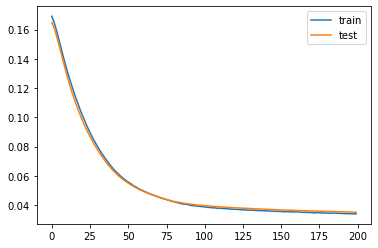

342/342 [==============================] - 1s 2ms/step
Val RMSE: 0.075
Val MAE: 0.035


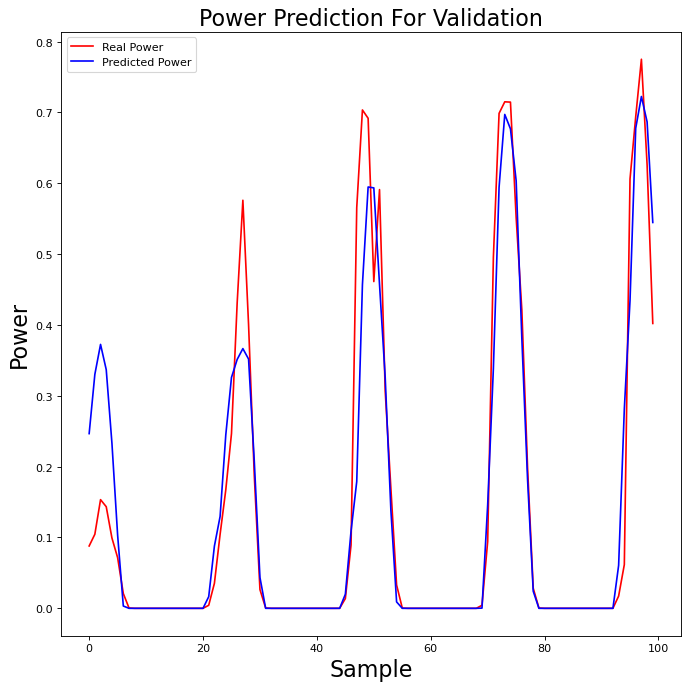

In [4]:
#solar power 1
# split into train and test sets
n_train_sample1 = int(len(values)/3)
train1 = values_[:n_train_sample1, :]
val1 = values_test_[:int(len(values_test)/3), :]
# split into input and outputs
train_X_1, train_y_1 = train1[:, :-1], train1[:, -1]
val_X_1, val_y_1 = val1[:, :-1], val1[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X_1 = train_X_1.reshape((train_X_1.shape[0], 1, train_X_1.shape[1]))
val_X_1 = val_X_1.reshape((val_X_1.shape[0], 1, val_X_1.shape[1]))
print(train_X_1.shape, train_y_1.shape, val_X_1.shape, val_y_1.shape)

# design network
model1 = Sequential()
model1.add(LSTM(200,activation='softmax', input_shape=(train_X_1.shape[1], train_X_1.shape[2])))
model1.add(Dropout(0.1))
model1.add(Dense(1, activation='relu'))
model1.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
mcp = ModelCheckpoint(os.path.join("best_model.h5"), monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')#, save_freq = 'epoch')
model1.summary()
# fit network
history1 = model1.fit(train_X_1, train_y_1, epochs=200, batch_size=72, validation_data=(val_X_1, val_y_1), verbose=2, shuffle=False,callbacks=[callback, mcp])
# plot history
pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
saved_model1 = tf.keras.models.load_model('best_model.h5')
yhat_1 = saved_model1.predict(val_X_1)
val_X_1 = val_X_1.reshape((val_X_1.shape[0], val_X_1.shape[2]))
# invert scaling for forecast
inv_yhat_1 = concatenate((yhat_1, val_X_1[:, 1:]), axis=1)
#inv_yhat_1 = scaler.inverse_transform(inv_yhat_1)
inv_yhat_1 = inv_yhat_1[:,0]
# invert scaling for actual
val_y_1 = val_y_1.reshape((len(val_y_1), 1))
inv_y_1 = concatenate((val_y_1, val_X_1[:, 1:]), axis=1)
#inv_y_1 = scaler.inverse_transform(inv_y_1)
inv_y_1 = inv_y_1[:,0]
# calculate RMSE and MAE
rmse_val_1 = sqrt(mean_squared_error(inv_y_1, inv_yhat_1))
print('Val RMSE: %.3f' % rmse_val_1)
mae_val_1 = mean_absolute_error(inv_y_1, inv_yhat_1)
print('Val MAE: %.3f' % mae_val_1)

pyplot.figure(figsize=(10, 10), dpi=80, facecolor = 'w', edgecolor = 'k')
pyplot.plot(inv_y_1[0:100], color='red', label='Real Power')
pyplot.plot(inv_yhat_1[0:100], color = 'blue', label = 'Predicted Power')
pyplot.title('Power Prediction For Validation', fontsize = 20)
pyplot.xlabel('Sample', fontsize=20)
pyplot.ylabel('Power', fontsize = 20)
pyplot.legend(loc = 'best')
pyplot.show()


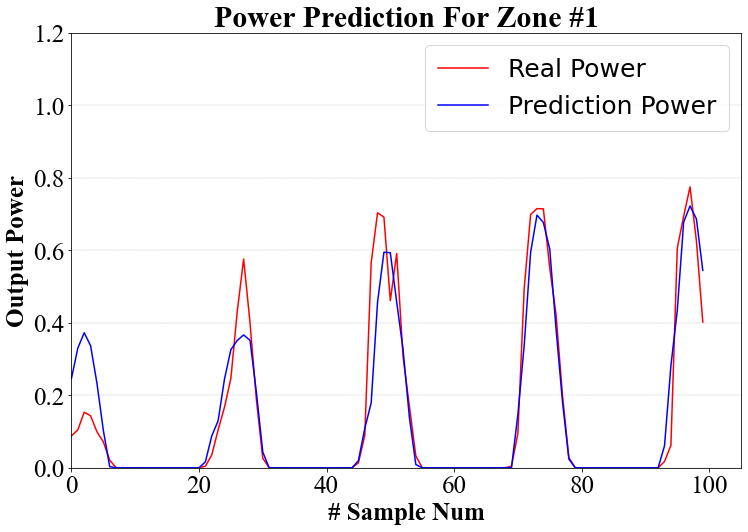

In [5]:
pyplot.figure(figsize=(12,8))
pyplot.grid(axis = 'y',linestyle = '--', linewidth = 0.4)
csfont = {'fontname':'Times New Roman'}
pyplot.title("Power Prediction For Zone #1",fontweight ='bold',**csfont,fontsize = 30)
pyplot.xlabel("# Sample Num",**csfont,fontweight ='bold', size=25)
pyplot.ylabel("Output Power",**csfont,fontweight ='bold', size=25)

pyplot.ylim(0, 1.2) 

pyplot.xlim(0, 105) 

pyplot.xticks(**csfont, fontsize = 25)
pyplot.yticks(**csfont, fontsize = 25)

pyplot.plot(inv_y_1[0:100], color='red', label='Real Power')
pyplot.plot(inv_yhat_1[0:100], color = 'blue', label = 'Predicted Power')


pyplot.legend(["Real Power","Prediction Power"], loc ="best", borderpad=0.5, labelspacing=0.5, fontsize=25)
pyplot.savefig('Zone1.pdf')  

(10944, 1, 312) (10944,) (10943, 1, 312) (10943,)
Epoch 1/200

Epoch 1: val_loss improved from inf to 0.19763, saving model to best_model2.h5
152/152 - 2s - loss: 0.1881 - val_loss: 0.1976 - 2s/epoch - 14ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.19763 to 0.19520, saving model to best_model2.h5
152/152 - 1s - loss: 0.1853 - val_loss: 0.1952 - 1s/epoch - 8ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.19520 to 0.19197, saving model to best_model2.h5
152/152 - 1s - loss: 0.1820 - val_loss: 0.1920 - 1s/epoch - 8ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.19197 to 0.18791, saving model to best_model2.h5
152/152 - 1s - loss: 0.1782 - val_loss: 0.1879 - 1s/epoch - 7ms/step
Epoch 5/200

Epoch 5: val_loss improved from 0.18791 to 0.18310, saving model to best_model2.h5
152/152 - 1s - loss: 0.1739 - val_loss: 0.1831 - 1s/epoch - 7ms/step
Epoch 6/200

Epoch 6: val_loss improved from 0.18310 to 0.17814, saving model to best_model2.h5
152/152 - 1s - loss: 0.1694 - va

Epoch 50/200

Epoch 50: val_loss improved from 0.06387 to 0.06296, saving model to best_model2.h5
152/152 - 1s - loss: 0.0571 - val_loss: 0.0630 - 1s/epoch - 7ms/step
Epoch 51/200

Epoch 51: val_loss improved from 0.06296 to 0.06212, saving model to best_model2.h5
152/152 - 1s - loss: 0.0561 - val_loss: 0.0621 - 1s/epoch - 7ms/step
Epoch 52/200

Epoch 52: val_loss improved from 0.06212 to 0.06133, saving model to best_model2.h5
152/152 - 1s - loss: 0.0551 - val_loss: 0.0613 - 1s/epoch - 7ms/step
Epoch 53/200

Epoch 53: val_loss improved from 0.06133 to 0.06056, saving model to best_model2.h5
152/152 - 1s - loss: 0.0542 - val_loss: 0.0606 - 1s/epoch - 8ms/step
Epoch 54/200

Epoch 54: val_loss improved from 0.06056 to 0.05989, saving model to best_model2.h5
152/152 - 1s - loss: 0.0533 - val_loss: 0.0599 - 1s/epoch - 8ms/step
Epoch 55/200

Epoch 55: val_loss improved from 0.05989 to 0.05924, saving model to best_model2.h5
152/152 - 1s - loss: 0.0525 - val_loss: 0.0592 - 1s/epoch - 7ms/ste


Epoch 99: val_loss improved from 0.04795 to 0.04784, saving model to best_model2.h5
152/152 - 1s - loss: 0.0396 - val_loss: 0.0478 - 1s/epoch - 7ms/step
Epoch 100/200

Epoch 100: val_loss improved from 0.04784 to 0.04774, saving model to best_model2.h5
152/152 - 1s - loss: 0.0394 - val_loss: 0.0477 - 1s/epoch - 7ms/step
Epoch 101/200

Epoch 101: val_loss improved from 0.04774 to 0.04764, saving model to best_model2.h5
152/152 - 1s - loss: 0.0393 - val_loss: 0.0476 - 1s/epoch - 7ms/step
Epoch 102/200

Epoch 102: val_loss improved from 0.04764 to 0.04754, saving model to best_model2.h5
152/152 - 1s - loss: 0.0392 - val_loss: 0.0475 - 1s/epoch - 7ms/step
Epoch 103/200

Epoch 103: val_loss improved from 0.04754 to 0.04744, saving model to best_model2.h5
152/152 - 1s - loss: 0.0391 - val_loss: 0.0474 - 1s/epoch - 7ms/step
Epoch 104/200

Epoch 104: val_loss improved from 0.04744 to 0.04734, saving model to best_model2.h5
152/152 - 1s - loss: 0.0390 - val_loss: 0.0473 - 1s/epoch - 7ms/step
E

152/152 - 1s - loss: 0.0358 - val_loss: 0.0448 - 1s/epoch - 7ms/step
Epoch 148/200

Epoch 148: val_loss improved from 0.04481 to 0.04477, saving model to best_model2.h5
152/152 - 1s - loss: 0.0358 - val_loss: 0.0448 - 1s/epoch - 7ms/step
Epoch 149/200

Epoch 149: val_loss improved from 0.04477 to 0.04474, saving model to best_model2.h5
152/152 - 1s - loss: 0.0357 - val_loss: 0.0447 - 1s/epoch - 7ms/step
Epoch 150/200

Epoch 150: val_loss improved from 0.04474 to 0.04470, saving model to best_model2.h5
152/152 - 1s - loss: 0.0356 - val_loss: 0.0447 - 1s/epoch - 7ms/step
Epoch 151/200

Epoch 151: val_loss improved from 0.04470 to 0.04467, saving model to best_model2.h5
152/152 - 1s - loss: 0.0356 - val_loss: 0.0447 - 1s/epoch - 7ms/step
Epoch 152/200

Epoch 152: val_loss improved from 0.04467 to 0.04463, saving model to best_model2.h5
152/152 - 1s - loss: 0.0355 - val_loss: 0.0446 - 1s/epoch - 7ms/step
Epoch 153/200

Epoch 153: val_loss improved from 0.04463 to 0.04459, saving model to b


Epoch 196: val_loss improved from 0.04341 to 0.04339, saving model to best_model2.h5
152/152 - 1s - loss: 0.0337 - val_loss: 0.0434 - 1s/epoch - 7ms/step
Epoch 197/200

Epoch 197: val_loss improved from 0.04339 to 0.04336, saving model to best_model2.h5
152/152 - 1s - loss: 0.0337 - val_loss: 0.0434 - 1s/epoch - 7ms/step
Epoch 198/200

Epoch 198: val_loss improved from 0.04336 to 0.04333, saving model to best_model2.h5
152/152 - 1s - loss: 0.0336 - val_loss: 0.0433 - 1s/epoch - 7ms/step
Epoch 199/200

Epoch 199: val_loss improved from 0.04333 to 0.04331, saving model to best_model2.h5
152/152 - 1s - loss: 0.0336 - val_loss: 0.0433 - 1s/epoch - 7ms/step
Epoch 200/200

Epoch 200: val_loss improved from 0.04331 to 0.04328, saving model to best_model2.h5
152/152 - 1s - loss: 0.0336 - val_loss: 0.0433 - 1s/epoch - 7ms/step


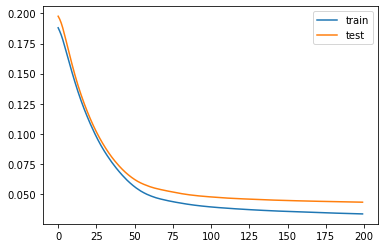

342/342 [==============================] - 1s 2ms/step
Val RMSE: 0.088
Val MAE: 0.043


In [6]:
# Solar Power 2
n_train_sample2 = 10000
train2 = values_[int(len(values)/3):int(len(values)/3)*2, :]
val2 = values_test_[int(len(values_test)/3):2*(int(len(values_test)/3)), :]
# split into input and outputs
train_X_2, train_y_2 = train2[:, :-1], train2[:, -1]
val_X_2, val_y_2 = val2[:, :-1], val2[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X_2 = train_X_2.reshape((train_X_2.shape[0], 1, train_X_2.shape[1]))
val_X_2 = val_X_2.reshape((val_X_2.shape[0], 1, val_X_2.shape[1]))
print(train_X_2.shape, train_y_2.shape, val_X_2.shape, val_y_2.shape)

# design network
model2 = Sequential()
model2.add(LSTM(200,activation='softmax', input_shape=(train_X_2.shape[1], train_X_2.shape[2])))
model2.add(Dense(1,activation='relu'))
model2.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
mcp = ModelCheckpoint(os.path.join("best_model2.h5"), monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')#, save_freq = 'epoch')

# fit network
history2 = model2.fit(train_X_2, train_y_2, epochs=200, batch_size=72, validation_data=(val_X_2, val_y_2), verbose=2, shuffle=False,callbacks=[callback, mcp])
# plot history
pyplot.plot(history2.history['loss'], label='train')
pyplot.plot(history2.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
saved_model2 = tf.keras.models.load_model('best_model2.h5')
yhat_2 = saved_model2.predict(val_X_2)
val_X_2 = val_X_2.reshape((val_X_2.shape[0], val_X_2.shape[2]))
# invert scaling for forecast
inv_yhat_2 = concatenate((yhat_2, val_X_2[:, 1:]), axis=1)
#inv_yhat_2 = scaler.inverse_transform(inv_yhat_2)
inv_yhat_2 = inv_yhat_2[:,0]
# invert scaling for actual
val_y_2 = val_y_2.reshape((len(val_y_2), 1))
inv_y_2 = concatenate((val_y_2, val_X_2[:, 1:]), axis=1)
#inv_y_2 = scaler.inverse_transform(inv_y_2)
inv_y_2 = inv_y_2[:,0]
# calculate RMSE and MAE
rmse_val_2 = sqrt(mean_squared_error(inv_y_2, inv_yhat_2))
print('Val RMSE: %.3f' % rmse_val_2)
mae_val_2 = mean_absolute_error(inv_y_2, inv_yhat_2)
print('Val MAE: %.3f' % mae_val_2)




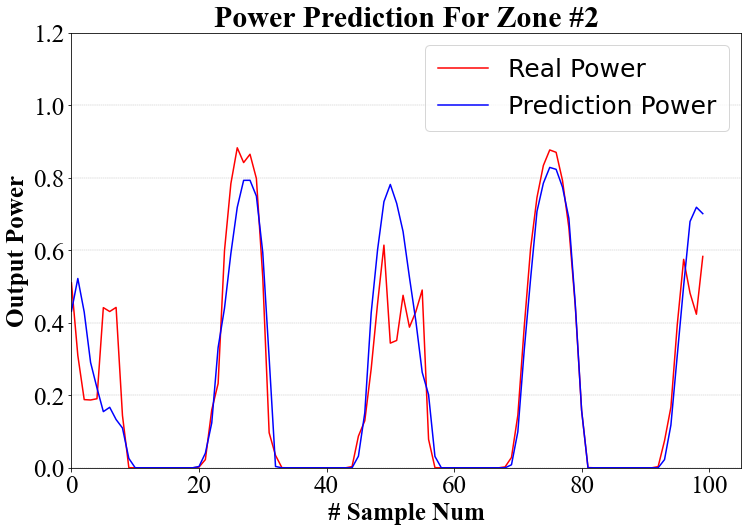

In [7]:
pyplot.figure(figsize=(12,8))
pyplot.grid(axis = 'y',linestyle = '--', linewidth = 0.4)
csfont = {'fontname':'Times New Roman'}
pyplot.title("Power Prediction For Zone #2",fontweight ='bold',**csfont,fontsize = 30)
pyplot.xlabel("# Sample Num",**csfont,fontweight ='bold', size=25)
pyplot.ylabel("Output Power",**csfont,fontweight ='bold', size=25)

pyplot.ylim(0, 1.2) 

pyplot.xlim(0, 105) 

pyplot.xticks(**csfont, fontsize = 25)
pyplot.yticks(**csfont, fontsize = 25)

pyplot.plot(inv_y_2[0:100], color='red', label='Real Power')
pyplot.plot(inv_yhat_2[0:100], color = 'blue', label = 'Predicted Power')


pyplot.legend(["Real Power","Prediction Power"], loc ="best", borderpad=0.5, labelspacing=0.5, fontsize=25)
pyplot.savefig('Zone2.pdf')  





(10920, 1, 312) (10920,) (4370, 1, 312) (4370,)
Epoch 1/200

Epoch 1: val_loss improved from inf to 0.17512, saving model to best_model3.h5
152/152 - 2s - loss: 0.1969 - val_loss: 0.1751 - 2s/epoch - 15ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.17512
152/152 - 1s - loss: 0.1969 - val_loss: 0.1751 - 1s/epoch - 7ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.17512
152/152 - 1s - loss: 0.1969 - val_loss: 0.1751 - 957ms/epoch - 6ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.17512
152/152 - 1s - loss: 0.1969 - val_loss: 0.1751 - 954ms/epoch - 6ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.17512
152/152 - 1s - loss: 0.1969 - val_loss: 0.1751 - 936ms/epoch - 6ms/step
Epoch 6/200

Epoch 6: val_loss did not improve from 0.17512
152/152 - 1s - loss: 0.1969 - val_loss: 0.1751 - 939ms/epoch - 6ms/step
Epoch 7/200

Epoch 7: val_loss did not improve from 0.17512
152/152 - 1s - loss: 0.1969 - val_loss: 0.1751 - 952ms/epoch - 6ms/step
E

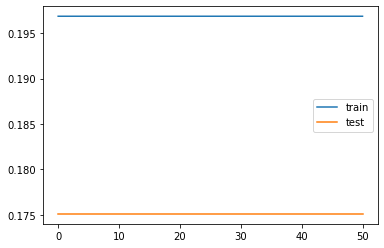

137/137 [==============================] - 0s 2ms/step
Val RMSE: 0.313
Val MAE: 0.175


In [8]:
# Solar Power 3
train3 = values_[2*(int(len(values)/3)):, :]
val3 = values_test_[2*(int(len(values_test)/3)):, :]
# split into input and outputs
train_X_3, train_y_3 = train3[:, :-1], train3[:, -1]
val_X_3, val_y_3 = val3[:, :-1], val3[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X_3 = train_X_3.reshape((train_X_3.shape[0], 1, train_X_3.shape[1]))
val_X_3 = val_X_3.reshape((val_X_3.shape[0], 1, val_X_3.shape[1]))
print(train_X_3.shape, train_y_3.shape, val_X_3.shape, val_y_3.shape)

# design network
model3 = Sequential()
model3.add(LSTM(200,activation='softmax', input_shape=(train_X_3.shape[1], train_X_3.shape[2])))
model3.add(Dropout(0.1))
model3.add(Dense(1,activation='relu'))
model3.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
mcp = ModelCheckpoint(os.path.join("best_model3.h5"), monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')#, save_freq = 'epoch')

# fit network
history3 = model3.fit(train_X_3, train_y_3, epochs=200, batch_size=72, validation_data=(val_X_3, val_y_3), verbose=2, shuffle=False, callbacks=[callback, mcp] )
# plot history
pyplot.plot(history3.history['loss'], label='train')
pyplot.plot(history3.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
saved_model3 = tf.keras.models.load_model('best_model3.h5')
yhat_3 = saved_model3.predict(val_X_3)
val_X_3 = val_X_3.reshape((val_X_3.shape[0], val_X_3.shape[2]))
# invert scaling for forecast
inv_yhat_3 = concatenate((yhat_3, val_X_3[:, 1:]), axis=1)
#inv_yhat_3 = scaler.inverse_transform(inv_yhat_3)
inv_yhat_3 = inv_yhat_3[:,0]
# invert scaling for actual
val_y_3 = val_y_3.reshape((len(val_y_3), 1))
inv_y_3 = concatenate((val_y_3, val_X_3[:, 1:]), axis=1)
#inv_y_3 = scaler.inverse_transform(inv_y_3)
inv_y_3 = inv_y_3[:,0]
# calculate RMSE and MAE
rmse_val_3 = sqrt(mean_squared_error(inv_y_3, inv_yhat_3))
print('Val RMSE: %.3f' % rmse_val_3)
mae_val_3 = mean_absolute_error(inv_y_3, inv_yhat_3)
print('Val MAE: %.3f' % mae_val_3)





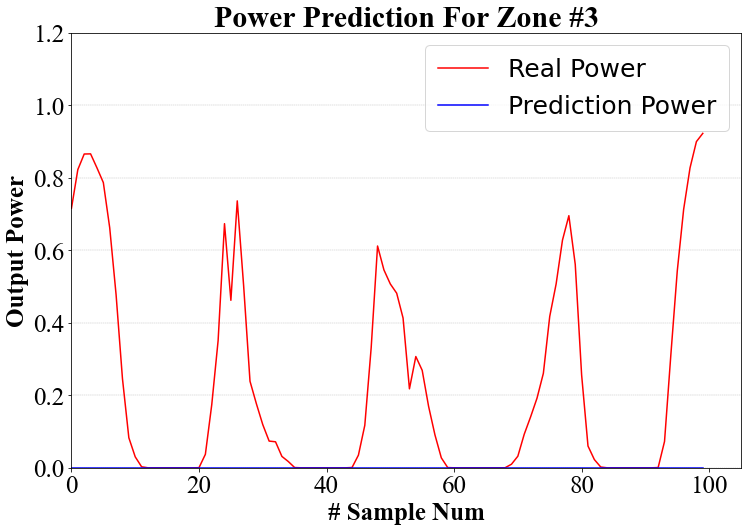

In [9]:
pyplot.figure(figsize=(12,8))
pyplot.grid(axis = 'y',linestyle = '--', linewidth = 0.4)
csfont = {'fontname':'Times New Roman'}
pyplot.title("Power Prediction For Zone #3",fontweight ='bold',**csfont,fontsize = 30)
pyplot.xlabel("# Sample Num",**csfont,fontweight ='bold', size=25)
pyplot.ylabel("Output Power",**csfont,fontweight ='bold', size=25)

pyplot.ylim(0, 1.2) 

pyplot.xlim(0, 105) 

pyplot.xticks(**csfont, fontsize = 25)
pyplot.yticks(**csfont, fontsize = 25)

pyplot.plot(inv_y_3[0:100], color='red', label='Real Power')
pyplot.plot(inv_yhat_3[0:100], color = 'blue', label = 'Predicted Power')


pyplot.legend(["Real Power","Prediction Power"], loc ="best", borderpad=0.5, labelspacing=0.5, fontsize=25)
pyplot.savefig('Zone3.pdf')  



